In [ ]:
!pip install natsort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import random
import itertools
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted
from os import makedirs, listdir
from os.path import join, exists, isdir
from PIL import Image, ImageChops, ImageEnhance

import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.applications import (MobileNetV2, Xception, InceptionV3, EfficientNetB7, ResNet101, NASNetLarge, 
                                           VGG19, VGG16, DenseNet201)
from tensorflow.keras.applications import (mobilenet_v2, xception, inception_v3, efficientnet, resnet, nasnet, vgg19, 
                                           vgg16, densenet)

np.random.seed(2)
plt.rcParams['figure.dpi'] = 100 #matplotlib
mpl.rcParams['figure.figsize'] = (8, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
class Config:
    CASIA1 = "../input/casia-dataset/CASIA1"
    CASIA2 = "../input/casia-dataset/CASIA2"
    autotune = tf.data.experimental.AUTOTUNE
    epochs = 30
    batch_size = 32
    lr = 1e-3      #10 power -3
    name = 'xception'
    n_labels = 2
    image_size = (224, 224)
    decay = 1e-6
    momentum = 0.95
    nesterov = False

In [ ]:

models = {
    'densenet': DenseNet201,
    'xception': Xception,
    'inceptionv3': InceptionV3,
    'effecientnetb7': EfficientNetB7,
    'vgg19': VGG19,
    'vgg16': VGG16,
    'nasnetlarge': NASNetLarge,
    'mobilenetv2': MobileNetV2,
    'resnet': ResNet101
}


preprocess = {
    'densenet': densenet.preprocess_input,
    'xception': xception.preprocess_input,
    'inceptionv3': inception_v3.preprocess_input,
    'effecientnetb7': efficientnet.preprocess_input,
    'vgg19': vgg19.preprocess_input,
    'vgg16': vgg16.preprocess_input,
    'nasnetlarge': nasnet.preprocess_input,
      'mobilenetv2': mobilenet_v2.preprocess_input,
    'resnet': resnet.preprocess_input
}

In [ ]:
# source = https://stackoverflow.com/a/62010096/6118987
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality]) #quantfy compressions

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
       items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

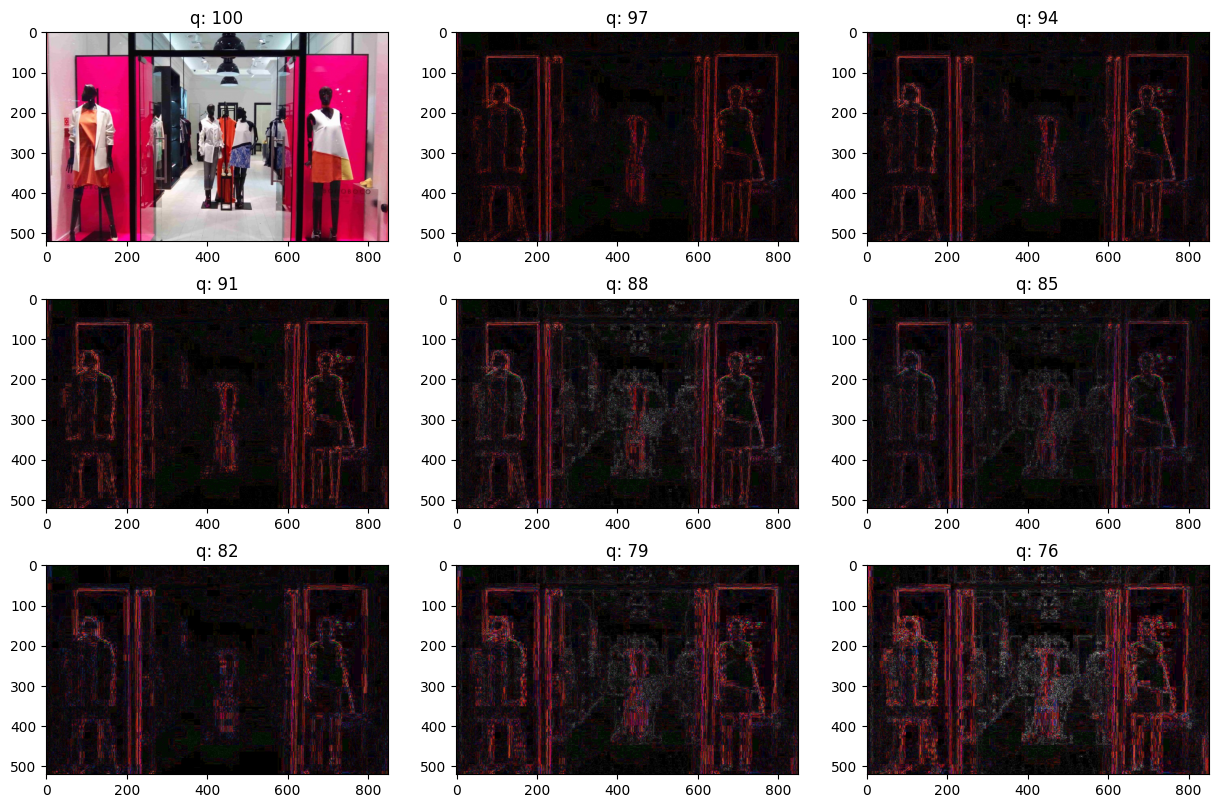

In [ ]:
p = '/content/Bohoboco-window-display-pink-and-red-2-1-850x520.jpg'

orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0 #normalizing  image  into 0 or 1 range (pixel value ranges from 0-255)
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

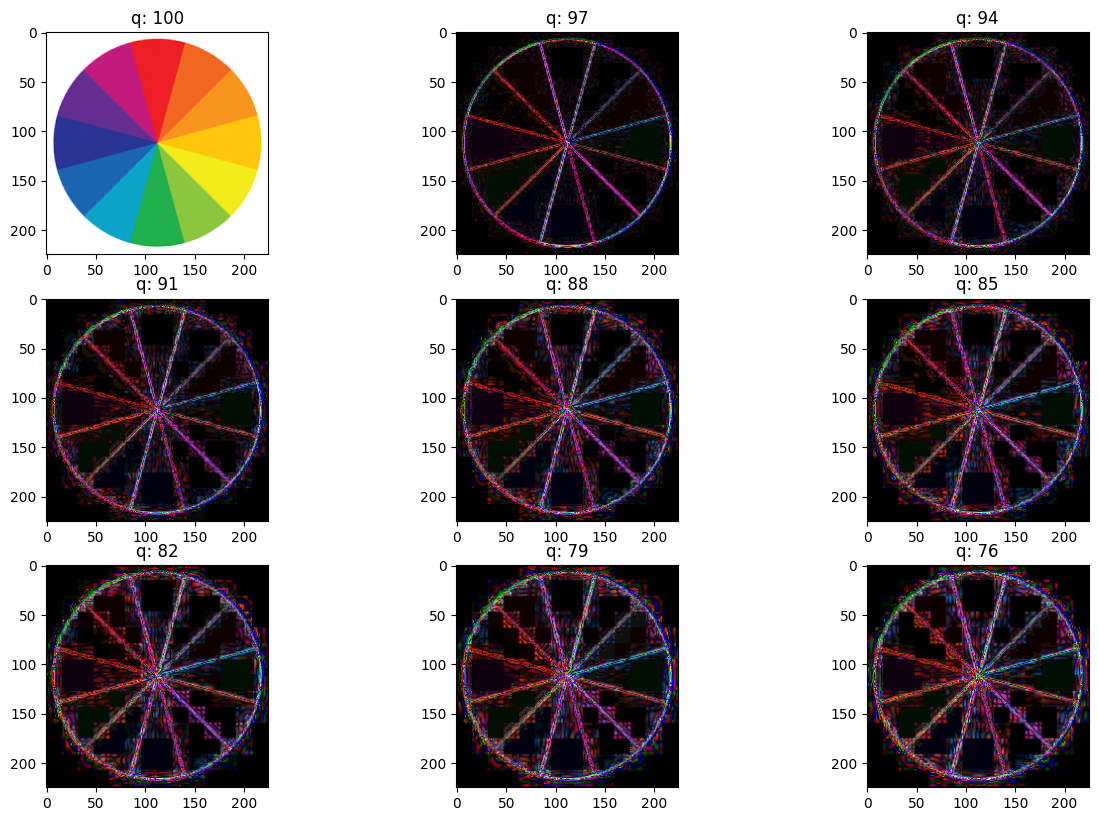

In [ ]:
p = '/content/color.png'

orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [ ]:
import albumentations as A
from albumentations import OneOf, Compose

@tf.function
def tensor_aug(img):
    img = tf.image.random_flip_left_right(img, 5)   #dimensions-0 or 1-true or false- flip #[[2], [1]], [[3], [4]]
    img = tf.image.random_flip_up_down(img, 5)
    return img

@tf.function
def batch_aug(images, labels):
    images = tf.map_fn(lambda img: tensor_aug(img), images)
    return images, labels
def ela_process(file_path):
    # https://www.tensorflow.org/guide/data
    QUALITY = 95
    SCALE = 15
    LABELS = np.array(['Au', 'Tp'])
    
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == LABELS
    # Integer encode the label
    label = tf.argmax(one_hot)
    label = tf.cast(label, tf.float32)
    
    # Generate the image
    orig = cv2.imread(file_path.numpy().decode('utf-8'))
    orig = cv2.resize(orig, (224, 224), interpolation = cv2.INTER_AREA)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    # Augmentation
#     orig = albumentation_aug(orig)
    # Save it in buffer
    _, buffer = cv2.imencode(".jpg", orig, [cv2.IMWRITE_JPEG_QUALITY, QUALITY])
    # get it from buffer and decode it to numpy array
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    # Compute the absolute difference
    diff = SCALE * (cv2.absdiff(orig, compressed_img))
    img = preprocess[Config.name](diff)
    
    return img, label

In [ ]:
jpg_pattern = '/content/drive/MyDrive/Colab Notebooks/CASIA2/*/*jp*g'
tif_pattern = '/content/drive/MyDrive/Colab Notebooks/CASIA2/*/*tif'

jpg_files = tf.data.Dataset.list_files(tif_pattern)
tif_files = tf.data.Dataset.list_files(jpg_pattern)

data_ds = jpg_files.concatenate(tif_files)

tensor_preprocess = lambda x: tf.py_function(ela_process, [x], [tf.float32, tf.float32])

n_data = data_ds.cardinality().numpy() #no.of elms in dataset
n_val = int(.2 * n_data)
data_ds = data_ds.shuffle(n_data) 

train_ds = data_ds.skip(n_val).map(
    tensor_preprocess, num_parallel_calls=Config.autotune).batch(Config.batch_size).map(
    batch_aug, num_parallel_calls=Config.autotune)

val_ds = data_ds.take(n_val).map(
    tensor_preprocess, num_parallel_calls=Config.autotune).batch(Config.batch_size)

for img, label in train_ds:
    print(label)
    break

tf.Tensor(
[0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 1.], shape=(32,), dtype=float32)


In [ ]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def create_model(optimizer, name='mobilenet', loss='categorical_crossentropy'):
    """
    Creates model based on the input name and freezes `blocks_to_train` blocks.
    Args: 
        optimizer(tf.keras.optimizers): initialized tensorflow optimizers.
        name(str): one of the keys in the `models` list.
        blocks_to_train: name of the blocks to freeze, if not given all the 
        layers will be trainable.
        loss: sets loss
        
    """
    
    base_model = models[name](include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    # model = Model(base_model.inputs, base_model.layers[-1].output)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.inputs, output)
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)
    return model

def scheduler(epoch):
    if epoch % 25 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.9)
        
    return K.get_value(model.optimizer.lr)

def generate_path(path_to_output, last_run=False):
    """
    Creates new path and returns the address.
    Notes:
        Sometimes accidently it happens that you overwrite your previous models. so
        this function is designed to create a new path for each run.
    """
    if not isdir(path_to_output):
        makedirs(path_to_output)
    
    runs = natsorted([path for path in listdir(path_to_output) if path.startswith("run_tf_data")])
    if last_run:
        if not bool(runs):
            path = join(path_to_output, "run_tf_data_1")
        else:
            path = join(path_to_output, runs[-1])

        return path
    if not bool(runs):
        path = join(path_to_output, 'run_tf_data_1')
    else:
        f = runs[-1].rsplit("data_")[1]
        path = join(path_to_output, 'run_tf_data_' + str(int(f) + 1))
    return path

In [ ]:
loss=tf.keras.losses.BinaryCrossentropy()
optimizer = SGD(lr=Config.lr, 
#                 decay=Config.decay, 
                momentum=Config.momentum, 
                nesterov=Config.nesterov)

model = create_model(optimizer, name=Config.name, loss=loss)

# model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
path = generate_path('checkpoints')
weight_path = join(path, 'weights')
tensorboard_path = join(path, 'logs')

makedirs(weight_path)
makedirs(tensorboard_path)

ckpt = ModelCheckpoint(
    filepath=weight_path, 
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=True
)

tensorboard = TensorBoard(
    log_dir=tensorboard_path, 
    write_graph=True
)

reduce_lr = LearningRateScheduler(scheduler)


callbacks = [ckpt, 
#              reduce_lr, 
             tensorboard]

In [ ]:
history = model.fit(
    train_ds,
    epochs=6,
    batch_size=Config.batch_size,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/6
315/315 [==============================] - 7643s 24s/step - loss: 0.5161 - accuracy: 0.0603 - precision: 0.7228 - recall: 0.5864 - auc: 0.8187 - prc: 0.7507 - val_loss: 0.3758 - val_accuracy: 0.0253 - val_precision: 0.7857 - val_recall: 0.8364 - val_auc: 0.9101 - val_prc: 0.8772
Epoch 2/6
315/315 [==============================] - 7913s 25s/step - loss: 0.3164 - accuracy: 0.0984 - precision: 0.8225 - recall: 0.8395 - auc: 0.9356 - prc: 0.9067 - val_loss: 0.3007 - val_accuracy: 0.0886 - val_precision: 0.7650 - val_recall: 0.9660 - val_auc: 0.9609 - val_prc: 0.9401
Epoch 3/6
315/315 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.1016 - precision: 0.8516 - recall: 0.8884 - auc: 0.9583 - prc: 0.9393 

In [ ]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(history, Config.name, 0)

In [ ]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], 
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1]) #limit of axis
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(history)

In [ ]:
val_ds_x = []
val_ds_y = []

for _, (val_x_batch, val_y_batch) in enumerate(val_ds):
    for val_x, val_y in zip(val_x_batch, val_y_batch):
        val_ds_x.append(val_x)
        val_ds_y.append(val_y)

val_data = (tf.convert_to_tensor(val_ds_x, dtype=tf.float32), 
            tf.convert_to_tensor(val_ds_y, dtype=tf.float32))
val_data[0].numpy().shape

In [ ]:
class_names = ['fake', 'authentic'] # make sure its correct

test_predictions_baseline = model.predict(val_data[0].numpy(), batch_size=Config.batch_size)

## CHECK
def plot_cm(label_matrix, predictions):
    
    preds = np.around(np.squeeze(predictions))
    gt = np.around(np.squeeze(predictions))
    
    cm = confusion_matrix(gt, 
                          preds,
                          labels=np.array([0, 1]))
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="icefire_r")
    indices = np.arange(len(class_names))
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

baseline_results = model.evaluate(val_data[0].numpy(), 
                                  val_data[1].numpy(),
                                  batch_size=Config.batch_size, 
                                  verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(val_data[1].numpy(), np.squeeze(test_predictions_baseline))